Universidade Estadual de Campinas - UNICAMP

Faculdade de Engenharia Elétrica e de Computação - FEEC

### IA048 – Aprendizado de Máquina

Alunos:
* Taylon xxxxx (RA: 0000000)
* Tiago Corrêa de Araújo de Amorim (RA: 100.675)

# Lista 01

## Tarefa

Trabalhar com a base de dados U.S. Airline Traffic Data, a qual contém informações referentes ao tráfego aéreo mensal norte-americano no período de 2003 a 2023, disponibilizadas pelo U.S. Department of Transportation’s (DOT) Bureau of Transportation Statistics. Em particular, vamos explorar a série temporal do número total de vôos (domésticos e internacionais).

Explorar um modelo linear para a previsão considerando que o horizonte de predição é L = 1 (passos à frente da série temporal).

## Dataset

* [Lista01\air traffic.csv](https://www.kaggle.com/datasets/yyxian/u-s-airline-traffic-data/data)

* This dataset provides U.S. monthly airline traffic from 2003 to 2023, including number of passengers, number of flights, revenue passenger-miles (RPM), available seat-miles (ASM) and load factor.

In [246]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet

from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import numpy as np
# import datetime as dt
# from itertools import chain
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline
# from scipy.interpolate import interp1d

In [199]:
df_original = pd.read_csv("air traffic.csv")
df_original.describe()

,Year,Month,Dom_Pax,Int_Pax,Pax,Dom_Flt,Int_Flt,Flt,Dom_RPM,Int_RPM,RPM,Dom_ASM,Int_ASM,ASM,Dom_LF,Int_LF,LF
count,249.000000,249.000000,2.490000e+02,2.490000e+02,2.490000e+02,249.000000,249.000000,249.000000,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,2.490000e+02,249.000000,249.000000,249.000000
mean,2012.879518,6.445783,5.520971e+07,7.392209e+06,6.260192e+07,706750.710843,64736.172691,771486.883534,4.957803e+07,1.918103e+07,6.875906e+07,6.131822e+07,2.413903e+07,8.545724e+07,79.938394,77.304940,79.286305
std,6.002817,3.442803,1.044055e+07,2.020273e+06,1.229211e+07,107054.971522,12129.622461,115686.728629,1.035558e+07,5.711621e+06,1.548875e+07,8.996673e+06,5.650437e+06,1.382385e+07,8.860562,10.907145,8.895700
min,2003.000000,1.000000,2.877290e+06,1.366090e+05,3.013899e+06,217262.000000,4996.000000,222280.000000,2.551127e+06,3.567620e+05,2.907889e+06,1.948908e+07,1.541419e+06,2.103050e+07,13.090000,23.150000,13.830000
25%,2008.000000,3.000000,5.098217e+07,6.395022e+06,5.766458e+07,662000.000000,61615.000000,727898.000000,4.458029e+07,1.660284e+07,6.182568e+07,5.655552e+07,2.173119e+07,7.919780e+07,77.720000,76.430000,76.940000
50%,2013.000000,6.000000,5.620010e+07,7.419187e+06,6.389913e+07,709933.000000,66557.000000,779011.000000,4.985794e+07,1.968901e+07,6.900519e+07,6.088909e+07,2.464572e+07,8.505191e+07,82.120000,79.910000,81.580000
75%,2018.000000,9.000000,6.089213e+07,8.567847e+06,6.944743e+07,781804.000000,71924.000000,848650.000000,5.568257e+07,2.266760e+07,7.803987e+07,6.626877e+07,2.770535e+07,9.255187e+07,85.240000,82.930000,84.070000
max,2023.000000,12.000000,7.537816e+07,1.243262e+07,8.781077e+07,890938.000000,82681.000000,964102.000000,7.226790e+07,3.137600e+07,1.036439e+08,8.199740e+07,3.532619e+07,1.173122e+08,89.960000,89.440000,89.140000


In [200]:
df_original['Date'] = pd.to_datetime(df_original[['Year', 'Month']].assign(day=1))
df_original.set_index('Date', inplace=True)
df_original = df_original[['Flt']]

## Item [a]
Exiba o gráfico da série temporal completa. Numa inspeção visual simples, é possível reconhecer ao menos três faixas distintas de comportamento aproximadamente “regular” na série: 
    
* (i) Jan/2003 a Ago/2008; 
* (ii) Set/2008 a Dez/2019; 
* (iiI) Jan/2020 a Set/2023.

Discuta possíveis razões históricas/econômicas para as
transições de comportamento.

In [201]:
def _is_list_or_set(a):
    if isinstance(a, list):
        return True
    if isinstance(a, set):
        return True
    return False

def to_datetime(a):
    if _is_list_or_set(a):
        a_new = []
        for ai in a:
            a_new.append(to_datetime(ai))
        if isinstance(a, set):
            a_new = set(a_new)
        return a_new
    else:
        return pd.to_datetime(a)

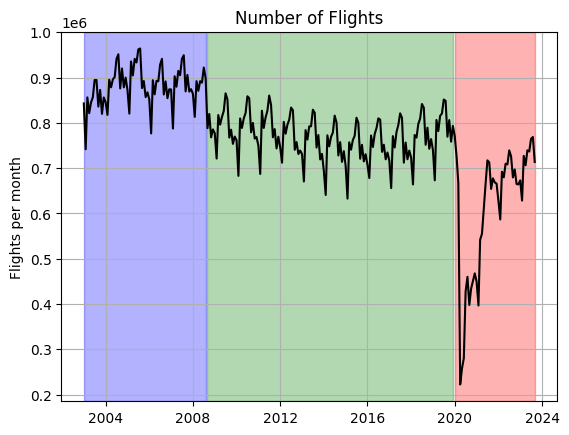

In [202]:
plt.plot(df_original['Flt'], color='black', linestyle='-')

date_regions = [
    ('2003-01-01', '2008-08-01'),
    ('2008-09-01', '2019-12-01'),
    ('2020-01-01', '2023-09-01')
]
date_regions = to_datetime(date_regions)

plt.axvspan(date_regions[0][0], date_regions[0][1], color='blue', alpha=0.3)
plt.axvspan(date_regions[1][0], date_regions[1][1], color='green', alpha=0.3)
plt.axvspan(date_regions[2][0], date_regions[2][1], color='red', alpha=0.3)

plt.ylabel('Flights per month')
plt.title('Number of Flights')
plt.grid(True)
plt.show()

Como os meses do ano não tem o mesmo número de dias, foi calculado o número médio de vôos por dia para cada mês da série. Nota-se que a série se torna mais suave, especialmente no mês de fevereiro.

Decidiu-se por utilizar esta série nas análises posteriores.

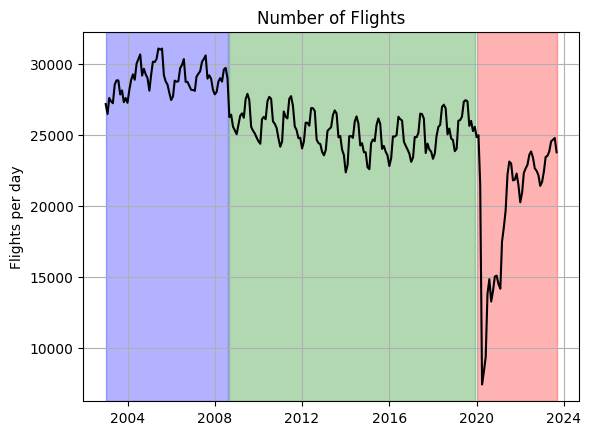

In [203]:
df_original['Days_in_month'] = df_original.index.days_in_month
df_original['Flt_per_day'] = df_original['Flt'] / df_original['Days_in_month']

plt.plot(df_original['Flt_per_day'],
         color='black', linestyle='-', marker='',
         label='Total')

plt.axvspan(date_regions[0][0], date_regions[0][1], color='blue', alpha=0.3)
plt.axvspan(date_regions[1][0], date_regions[1][1], color='green', alpha=0.3)
plt.axvspan(date_regions[2][0], date_regions[2][1], color='red', alpha=0.3)

plt.ylabel('Flights per day')
plt.title('Number of Flights')
plt.grid(True)
plt.show()

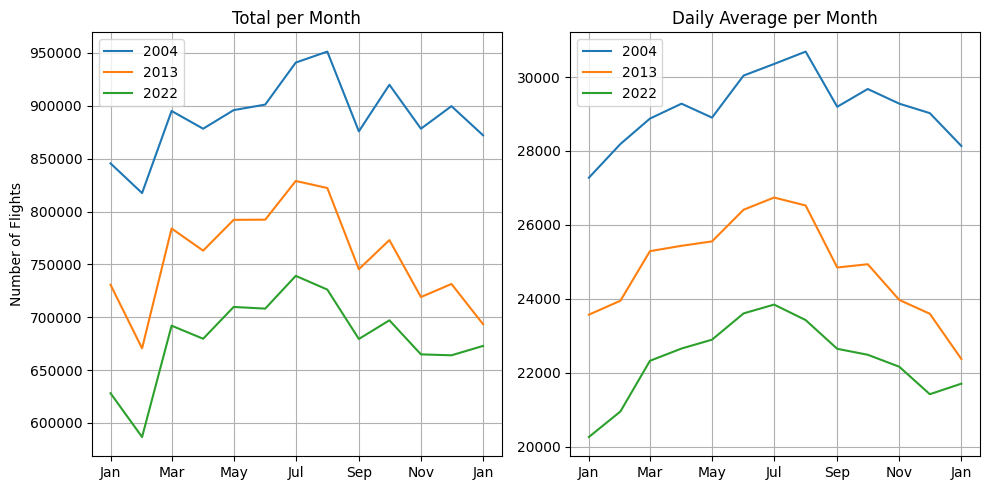

In [214]:
def year_plots(years, columns, titles):
    date_format = DateFormatter("%b")

    _, axs = plt.subplots(1, len(columns), figsize=(len(columns)*5, 5))

    for i, (column,title) in enumerate(zip(columns, titles)):
        for year in years:
            axs[i].plot(df.loc[f'{years[0]}-01-01':f'{years[0]+1}-01-01'].index,
                        df_original.loc[f'{year}-01-01':f'{year+1}-01-01'][column],
                        linestyle='-', label=year)
        axs[i].xaxis.set_major_formatter(date_format)
        axs[i].set_title(title)
        axs[i].legend()
        axs[i].grid(True)
    axs[0].set_ylabel('Number of Flights')
    plt.tight_layout()
    plt.show()

year_plots([2004, 2013, 2022],
           ['Flt', 'Flt_per_day'],
           ['Total per Month', 'Daily Average per Month'])

Nova tentativa foi feita utilizando o número de dias úteis por mês. Os resultados não foram bons.

In [205]:
def get_workdays(date):
    year = date.year
    month = date.month
    start_date = pd.Timestamp(year, month, 1)
    if month == 12:
        month = 0
        year = year+1
    end_date = pd.Timestamp(year, month+1, 1) - pd.Timedelta(1)
    return len(pd.bdate_range(start_date, end_date))

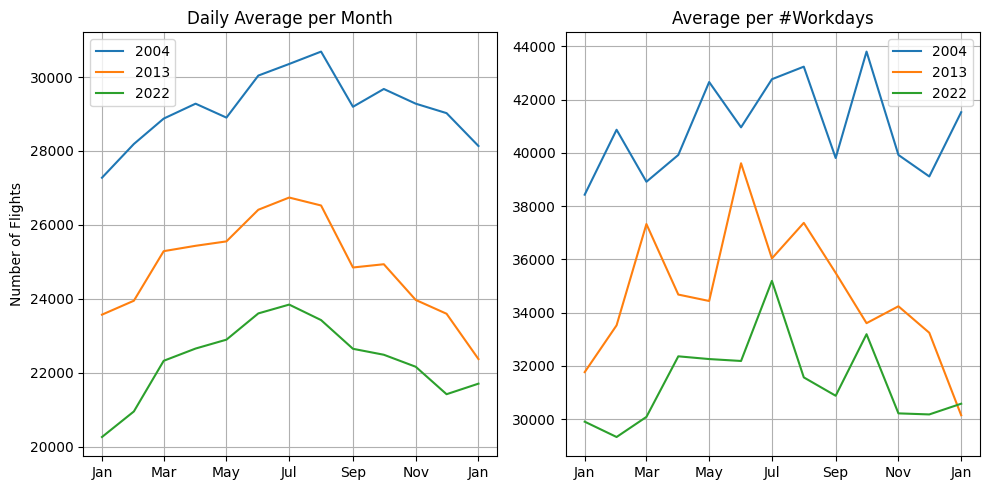

In [215]:
df_original['Workdays'] = [get_workdays(i) for i in df_original.index]
df_original['Flt_per_workday'] = df_original['Flt'] / df_original['Workdays']

year_plots([2004, 2013, 2022],
           ['Flt_per_day', 'Flt_per_workday'],
           ['Daily Average per Month', 'Average per #Workdays'])

**Resposta**

O primeiro período (azul) é de certa normalidade na economia americana. O início do período em verde é marcado pela crise financeira do _subprime_ (estouro da bolha imobiliária nos EUA devido a empréstimos sem lastro e preços de imóveis inflacionados). O período em vermelho corresponde à crise sanitária causada pela pandemia de Covid-19.

## Item [b]

Divida a série em dois conjuntos:

* (i) **treinamento** e **validação**: com amostras de 2003 a 2019.
* (ii) **teste**: com amostras de 2020 a 2023.

Faça a análise de desempenho do preditor linear ótimo, no sentido de quadrados mínimos irrestrito considerando:

In [210]:
df = df_original[['Flt_per_day']]
df = df.rename(columns={'Flt_per_day':'y'})

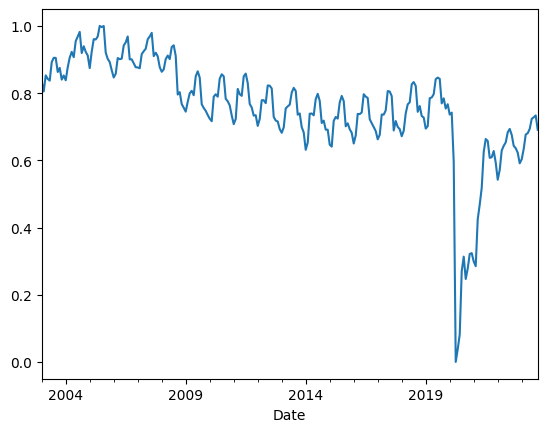

In [265]:
scaler = MinMaxScaler().fit(df['y'].values.reshape(-1, 1))
df['x_0'] = scaler.transform(df['y'].values.reshape(-1, 1))
df['x_0'].plot()
for k in range(24):
    df[f'x_{k+1}'] = df['x_0'].shift(periods=k+1)

In [213]:
limits = {
    'train-validation':('2003-01-01', '2019-12-01'),
    'test':('2020-01-01', '2023-09-01')
}

df_train_val = df.loc[limits['train-validation'][0]:limits['train-validation'][1]]
df_test = df.loc[limits['test'][0]:limits['test'][1]]

print(f'Total number of data points: {len(df)}')
print(f'Number of train + validation data points: {len(df_train_val)}')
print(f'Number of test data points: {len(df_test)}')


Total number of data points: 249
Number of train + validation data points: 204
Number of test data points: 45


4
40


In [241]:
def get_train_validation(df, validation_ratio, fold_number=1):
    max_fold_number = np.floor(1/validation_ratio-1).astype(int)
    if fold_number > max_fold_number:
        return None
    validation_size = np.floor(len(df_train_val) * validation_ratio).astype(int)
    validation_index = len(df_train_val) - validation_size * fold_number
    return df[:validation_index], df[validation_index:validation_index+validation_size]

In [242]:
k_variables = 1
variables_list = [f'x_{i+1}' for i in range(k_variables)]

validation_ratio = 0.2
max_fold_number = np.floor(1/validation_ratio)

df_train, df_validation = get_train_validation(df[k_variables:], validation_ratio, 1)

X_train = df_train[variables_list]
y_train = df_train['y']
X_validation = df_validation[variables_list]
y_validation = df_validation['y']

linear_model = ElasticNet(alpha = 0.1, l1_ratio=0.5)
linear_model.fit(X_train, y_train)
y_train_predict = linear_model.predict(X_train)
y_validation_predict = linear_model.predict(X_validation)

rmse_train = root_mean_squared_error(y_train, y_train_predict)
mae_train = mean_absolute_percentage_error(y_train, y_train_predict)
rmse_validation = root_mean_squared_error(y_validation, y_validation_predict)
mae_validation = mean_absolute_percentage_error(y_validation, y_validation_predict)

In [245]:
print(rmse_train)
print(rmse_validation)
print(mae_train)
print(mae_validation)

796.0714688522226
1870.9847836704348
0.022862457550992237
0.05664799475648223


### Item [b1]

A progressão do valor da raiz quadrada do erro quadrático médio (RMSE, do inglês _root mean squared
error_), junto aos dados de validação, em função do número de entradas (K) do preditor (desde K = 1
a K = 24). Apresente o gráfico obtido e busque tecer conjecturas sobre os motivos subjacentes a seu
comportamento.

### Item [b2]

O gráfico com as amostras de teste da série temporal e as respectivas estimativas geradas pela melhor
versão do preditor (i.e., usando o valor de K que levou ao mínimo erro de validação). Obtenha, também, o RMSE e o erro percentual absoluto médio (MAPE, do inglês _mean absolute percentage error_) para o conjunto de teste.

### Item [b3]

O gréfico com as amostras apenas dos dois últimos anos (2022 e 2023) e as estimativas geradas pelo
melhor preditor, além dos respectivos valores de RMSE e MAPE.

## Item [c]

Repita o procedimento detalhado nos itens **b1** e **b2**, mas adotando a seguinte divisão dos dados:

* (i) **treinamento**: amostras de 2003 a 2019.
* (ii) **validação**: amostras de 2020 e 2021.
* (iii) **teste**: amostras de 2022 e 2023.

Discuta os resultados obtidos e faça uma comparação com o cenário anterior (especialmente
com o que foi obtido no item **b3**).

In [198]:
#